# Find the partial correlations between each priming group in all stories and the loc template, soc template, and story vectors

## output: for each type of priming the partial correlation of each type of vector averaged across stories
## 12/17/20

In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
from sklearn.metrics import jaccard_score
import random
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from scipy import stats


from sklearn.decomposition import PCA #for cluster analysis
from gensim.models import KeyedVectors #for word embeddings
import matplotlib.pyplot as plt #for plotting
import os #for importing
import pickle #for loading transcripts
from scipy.stats import pearsonr 

# from _DRAFT_20200604_functions import * #includes constants and score function
from tqdm import tqdm_notebook #for progress bar

%autosave 5

Autosaving every 5 seconds


# 0. Importing story and template vectors and sums 

In [2]:
templates = pickle.load( open( 'c_template', "rb" ) )
recalls = pickle.load( open( 'c_recall', "rb" ) )
stories = pickle.load( open( 'c_stories', "rb" ) )
# sums
sums = pickle.load( open( "new_sums", "rb" ) )

In [44]:
norm = 0

# I. AVERAGING WEIGHTS
## A. get recall averages across different priming groups

In [45]:
story_order = [11,12,13,14,21,22,23,24,31,32,33,34,41,42,43,44]
recall_avg = {}

for key in story_order:
    # Loop through all conditions
    for i in range(0, 3):
        if i == 0:
            recall_avg[key] ={i: np.mean(recalls[key][i], axis = 0)}
        else:    
            recall_avg[key][i] = np.mean(recalls[key][i], axis = 0)

## B. Regressing out the non-correlated weights

In [47]:
# Partial correlation with soc: regress out soc and story, and correlate with loc
pc_loc = np.zeros((3,16))
count = 0

for key in recall_avg:
    loc = key%10
    soc = round(key/10)*10
    # Make the inputs of the regression
    # location template
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    # social template
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    # story vector
    story_vec = stories[key].reshape(stories[key].shape[0],-1)
    # Concatenating inputes
    inputs = np.concatenate((s_temp, story_vec), axis = 1)
    for i in range(0, 3):
        output = np.copy(recall_avg[key][i])
        model = LinearRegression().fit(inputs, output)
        ## Is subtracting the intercept correct?? 
        new_vec = output - np.dot(model.coef_, inputs.T)- model.intercept_
        # reshape
        new_vec = new_vec[:, np.newaxis]
        ## Should I norm?
        if norm == 1:
            new_vec = stats.zscore(new_vec)
        # partial correlation new_vec with loc template
        this_correl = np.corrcoef(new_vec.T, l_temp.T)
        pc_loc[i][count] = this_correl[0,1]
    count += 1
    
# Partial correlation with soc: regress out loc and story, and correlate with soc
pc_soc = np.zeros((3,16))
count = 0

for key in recall_avg:
    loc = key%10
    soc = round(key/10)*10
    # Make the inputs of the regression
    # location template
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    # social template
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    # story vector
    story_vec = stories[key].reshape(stories[key].shape[0],-1)
    # Concatenating inputes
    inputs = np.concatenate((l_temp, story_vec), axis = 1)
    for i in range(0, 3):
        output = np.copy(recall_avg[key][i])
        model = LinearRegression().fit(inputs, output)
        ## Is subtracting the intercept correct?? 
        new_vec = output - np.dot(model.coef_, inputs.T)- model.intercept_
        # reshape
        new_vec = new_vec[:, np.newaxis]
        ## Should I norm?
        if norm == 1:
            new_vec = stats.zscore(new_vec)
        # partial correlation new_vec with soc template
        this_correl = np.corrcoef(new_vec.T, s_temp.T)
        pc_soc[i][count] = this_correl[0,1]
    count += 1
    
# Partial correlation with story: regress out loc and soc, and correlate with story
pc_story = np.zeros((3,16))
count = 0

for key in recall_avg:
    loc = key%10
    soc = round(key/10)*10
    # Make the inputs of the regression
    # location template
    l_temp = templates[loc].reshape(templates[loc].shape[0],-1)
    # social template
    s_temp = templates[soc].reshape(templates[soc].shape[0],-1)
    # story vector
    story_vec = stories[key].reshape(stories[key].shape[0],-1)
    # Concatenating inputes
    inputs = np.concatenate((l_temp, s_temp), axis = 1)
    for i in range(0, 3):
        output = np.copy(recall_avg[key][i])
        model = LinearRegression().fit(inputs, output)
        ## Is subtracting the intercept correct?? 
        new_vec = output - np.dot(model.coef_, inputs.T)- model.intercept_
        # reshape
        new_vec = new_vec[:, np.newaxis]
        ## Should I norm?
        if norm == 1:
            new_vec = stats.zscore(new_vec)
        # partial correlation new_vec with soc template
        this_correl = np.corrcoef(new_vec.T, story_vec.T)
        pc_story[i][count] = this_correl[0,1]
    count += 1

## C. Avg across weights for each priming type and plot

In [48]:
np.mean(pc_loc, axis = 1)

array([0.09535877, 0.19017411, 0.10568758])

In [49]:
pc_loc

array([[-0.07350994,  0.13655586, -0.12411349,  0.03050598,  0.05671771,
        -0.14814745,  0.26152995,  0.38098654, -0.03627713,  0.23000524,
         0.10985352,  0.28637092, -0.08720676,  0.0902744 ,  0.30895948,
         0.10323552],
       [ 0.0616965 ,  0.6158353 , -0.02696461,  0.01036008,  0.2523115 ,
        -0.09568207,  0.32072373,  0.27778051,  0.18357174,  0.28042079,
         0.45738625,  0.24773673, -0.04346367,  0.15111861,  0.30033381,
         0.04962051],
       [-0.08323116,  0.11721514,  0.09085536,  0.11448905,  0.15187374,
        -0.01772798,  0.38978143,  0.24742875, -0.01578806,  0.09582808,
         0.20749649,  0.09490366, -0.01543228, -0.14251795,  0.27715752,
         0.17866951]])

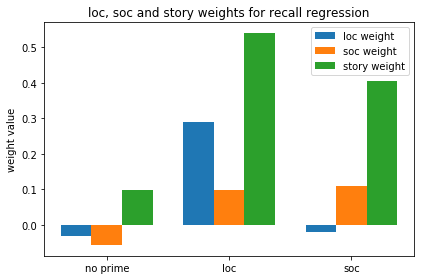

In [50]:
# loc weight
w0 = np.zeros((3,1))

# soc weight
w1 = np.zeros((3,1))

# story weight
w2 = np.zeros((3,1))

# assign values
w0[0] = np.mean(pc_loc, axis = 0)[0]
w0[1] = np.mean(pc_loc, axis = 0)[1]
w0[2] = np.mean(pc_loc, axis = 0)[2]

w1[0] = np.mean(pc_soc, axis = 0)[0]
w1[1] = np.mean(pc_soc, axis = 0)[1]
w1[2] = np.mean(pc_soc, axis = 0)[2]

w2[0] = np.mean(pc_story, axis = 0)[0]
w2[1] = np.mean(pc_story, axis = 0)[1]
w2[2] = np.mean(pc_story, axis = 0)[2]


w0 = w0.ravel()
w1 = w1.ravel()
w2 = w2.ravel()

#labels
labels = ['no prime', 'loc', 'soc']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x, w0, width, label='loc weight')
rects2 = ax.bar(x + width, w1, width, label='soc weight')
rects3 = ax.bar(x + width*2, w2, width, label='story weight')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight value')
ax.set_title('loc, soc and story weights for recall regression')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()

plt.show()


